In [1]:
"""
Adam Optimization.
Two dimensional Poisson equation example. Solution given by

u(x,y) = sin(pi*x) * sin(py*y).

"""
import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit
import optax

from ngrad.models import init_params, mlp
from ngrad.domains import Square, SquareBoundary
from ngrad.integrators import DeterministicIntegrator
from ngrad.utility import laplace

jax.config.update("jax_enable_x64", True)

tau = 1.

# random seed
seed = 0

# domains
interior = Square(1.)
boundary = SquareBoundary(1.)

# integrators
interior_integrator = DeterministicIntegrator(interior, 30)
boundary_integrator = DeterministicIntegrator(boundary, 30)
eval_integrator = DeterministicIntegrator(interior, 200)

# model
activation = lambda x : jnp.tanh(x)
layer_sizes = [2, 32, 1]
params = init_params(layer_sizes, random.PRNGKey(seed))
model = mlp(activation)
# v_model = vmap(model, (None, 0))
v_model = vmap(lambda params, x: model(params, x), (None, 0))

# solution
@jit
def u_star(x):
    return jnp.prod(jnp.sin(jnp.pi * x))

# rhs
@jit
def f(x):
    return 2. * jnp.pi**2 * u_star(x)

# compute residual
laplace_model = lambda params: laplace(lambda x: model(params, x))
residual = lambda params, x: (laplace_model(params)(x) + f(x))**2.
v_residual =  jit(vmap(residual, (None, 0)))

# loss
@jit
def interior_loss(params):
    return interior_integrator(lambda x: v_residual(params, x))

@jit
def boundary_loss(params):
    return tau * boundary_integrator(lambda x: v_model(params, x)**2)

@jit
def loss(params):
    return interior_loss(params) + boundary_loss(params)

# errors
error = lambda x: model(params, x) - u_star(x)
v_error = vmap(error, (0))
v_error_abs_grad = vmap(
        lambda x: jnp.dot(grad(error)(x), grad(error)(x))**0.5
        )

def l2_norm(f, integrator):
    return integrator(lambda x: (f(x))**2)**0.5


iterations = 20000
save_freq = 10

import numpy as np
data = np.empty((iterations // save_freq + 1, 5))

# optimizer settings
exponential_decay = optax.exponential_decay(
    init_value=0.001, 
    transition_steps=10000,
    transition_begin=15000,
    decay_rate=0.1,
    end_value=0.0000001
)

optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(params)
   
# adam gradient descent with line search
for iteration in range(iterations + 1):
    grads = grad(loss)(params)

    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    if iteration % save_freq == 0:
        # errors
        l2_error = l2_norm(v_error, eval_integrator)
        h1_error = l2_error + l2_norm(v_error_abs_grad, eval_integrator)
        
        data[iteration // save_freq, :] = [
            iteration,
            interior_loss(params),
            boundary_loss(params),
            l2_error,
            h1_error,
        ]
    
        print(
            f'Adam Iteration: {iteration}'
            f'\n  with loss: {interior_loss(params)} + {boundary_loss(params)} = {loss(params)}'
            f'\n  with error L2: {l2_error} and error H1: {h1_error}'
        )
        
jnp.save("data/adam.npy", data)


2024-01-01 20:18:11.069746: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.103). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Adam Iteration: 0
  with loss: 104.51494339246727 + 0.009229327105846227 = 104.52417271957312
  with error L2: 0.5412326359827202 and error H1: 2.763091061196618
Adam Iteration: 10
  with loss: 104.44134924079967 + 0.005257622531151757 = 104.44660686333081
  with error L2: 0.4799447814892569 and error H1: 2.701528196489088
Adam Iteration: 20
  with loss: 104.36976306194732 + 0.018377837361743046 = 104.38814089930906
  with error L2: 0.4547943296840913 and error H1: 2.6761846669839104
Adam Iteration: 30
  with loss: 104.29166402120086 + 0.022017302959736345 = 104.3136813241606
  with error L2: 0.4510525122754847 and error H1: 2.672022080878463
Adam Iteration: 40
  with loss: 104.18919863998455 + 0.0233732335807627 = 104.21257187356531
  with error L2: 0.4509282782936579 and error H1: 2.6712620964596807
Adam Iteration: 50
  with loss: 104.04356346886831 + 0.028172845564038682 = 104.07173631443236
  with error L2: 0.44696874219011595 and error H1: 2.6664492509982938
Adam Iteration: 60
  w

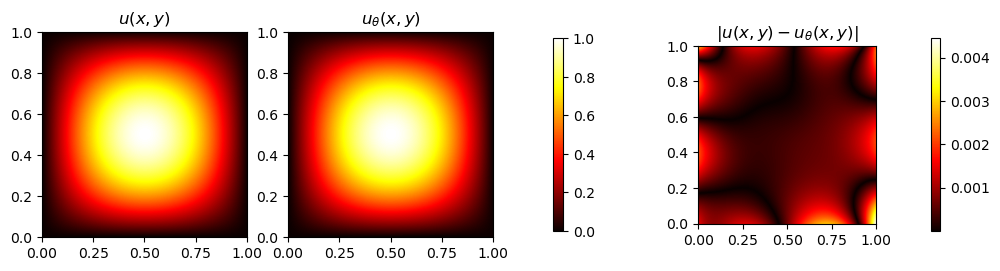

In [2]:
from util import save

n = 300
save("adam", n, u_star, v_model, params)